In [387]:
import os
import pandas as pd
from PIL import Image

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [385]:
dataset = "flickr30k"

In [386]:
paths = {"flickr30k": "/raid/datasets/f30k",
         "mscoco": "/raid/datasets/coco"}
path = paths[dataset]

In [388]:
# get labels

sub_folder = "bua"
annots = os.listdir(os.path.join(path, "features_36", sub_folder))

# test one
loaded = np.load(os.path.join(path, "features_36", sub_folder, annots[0]), allow_pickle=True)
print((loaded["info"]).tolist()["objects_id"])
print((loaded["info"]).tolist()["objects_conf"])

KeyboardInterrupt: 

In [ ]:
files = os.listdir("/raid/datasets/coco/features_36/bua/")

files[0]

loaded = np.load(os.path.join(path, "features_36", sub_folder, files[0]), allow_pickle=True)
print(list(loaded.keys()))
print(loaded["info"].tolist())

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

def filter_stop_words(sent):
    stop_words = set(stopwords.words('english'))

    word_tokens = word_tokenize(sent)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    return " ".join(filtered_sentence)

In [869]:
def get_valid_key_names(inv_dict, k=10, verbose=False, filter_words=None):
    sorted_keys = sorted(inv_dict, key=lambda x: len(set([l // 5 for l in inv_dict[x]])), reverse=True)
    valid_label_names = []
    count = 0
    for key in sorted_keys:
        if filter_words is not None:
            if key in filter_words:
                continue
        if verbose:
            print(key)
            print(len(inv_dict[key]))
        if len(key) > 2:
            valid_label_names.append(key)
        count += 1
        if count == k:
            break
    return valid_label_names

In [884]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


# load img paths
def is_img(img_name):
    return img_name.endswith(".jpg") or img_name.endswith(".jpeg") or img_name.endswith(".png")


def load_flickr(path, num_imgs=None):
    img_folder = os.path.join(path, "images")
    imgs = [i for i in os.listdir(img_folder) if is_img(i)]
    imgs = sorted(imgs, key = lambda x: int(x.split(".")[0]))
    img_ids = [int(x.split(".")[0]) for x in imgs]
    img_paths = [os.path.join(img_folder, i) for i in imgs]

    # load captions
    captions = pd.read_csv(os.path.join(path, "captions.txt"), delimiter="|")
    captions["img_idx"] = captions["image_name"].apply(lambda x: int(x.split(".")[0]))
    captions = captions.sort_values("img_idx")
    del captions["img_idx"]
    
    if num_imgs is not None:
        imgs = imgs[:num_imgs]
        img_paths = imgs[:num_imgs]
        img_ids = img_ids[:num_imgs]
        captions = captions[:num_imgs * 5]
    
    # annotated bounding box labels:
    # from https://github.com/BryanPlummer/flickr30k_entities
    import sys
    sys.path.append("/raid/datasets")
    from flickr30k_entities.flickr30k_entities_utils import get_annotations, get_sentence_data
    from collections import defaultdict

    labels = []
    specific_dict = {}
    broad_dict = {}
    specific_inv_dict = defaultdict(list)
    broad_inv_dict = defaultdict(list)

    # load relations between img bounding boxes and captions
    for img_id in tqdm(img_ids):
        p = f"/raid/datasets/flickr30k_entities/Annotations/{img_id}.xml"
        annot = get_annotations(p)
        p = f"/raid/datasets/flickr30k_entities/Sentences/{img_id}.txt"
        sent_data = get_sentence_data(p)

        # get info from sentence data of which ids belong to image
        for caption in sent_data:
            phrases = caption["phrases"]
            for phrase in phrases:
                id_ = int(phrase["phrase_id"])

                phrase_spec = phrase["phrase"].lower()
                phrase_spec = filter_stop_words(phrase_spec)
                phrase_broad = phrase["phrase_type"][0].lower()

                broad_dict[id_] = phrase_broad
                broad_inv_dict[phrase_broad].append(id_)
                if len(phrase_spec) > 2:
                    specific_dict[id_] = phrase_spec
                    specific_inv_dict[phrase_spec].append(id_)
        # get info from bounding box about which phrase ids appear in the image
        bb_labels = [int(l) for l in list(annot["boxes"].keys()) if int(l) in specific_dict]
        scene_labels = [int(l) for l in annot["scene"] if int(l) in broad_dict]
        img_labels = list(set(bb_labels + scene_labels))
        img_labels = [int(l) for l in img_labels]
        labels.append(img_labels)

    print("Total number of labels: ", len(specific_inv_dict))
    num_spec_labels = 250
    filter_words = ["one", "something", "foreground", "background"]
    specific_label_names = get_valid_key_names(specific_inv_dict, k=num_spec_labels, filter_words=filter_words)
    filter_words = ["other", "scene", "notvisual"]
    broad_label_names = get_valid_key_names(broad_inv_dict, k=100, filter_words=filter_words)
    all_label_names = specific_label_names + broad_label_names
    print("Selected num of labels: ", len(all_label_names))
    print(all_label_names)

    figsize = (6, 10)
    if num_spec_labels > 100:
        figsize = (6, 20)
    elif num_spec_labels > 200:
        figsize = (6, 35)

    occurences_specific = [len(specific_inv_dict[k]) for k in specific_label_names]
    plt.figure(figsize=figsize)
    sns.barplot(y=specific_label_names, x=occurences_specific)
    plt.savefig("flickr30k/specific_occurences.png")
    plt.show()

    occurences_broad = [len(broad_inv_dict[k]) for k in broad_label_names]
    sns.barplot(y=broad_label_names, x=occurences_broad)
    plt.savefig("flickr30k/broad_occurences.png")
    plt.show()

    # calculate real labels
    ext_dict = {**broad_dict, **specific_dict}
    label_strs = []
    for label_list in labels:
        label_strs.append([ext_dict[l] for l in label_list if ext_dict[l] in all_label_names])

    #label_strs = [get_labels(l, broad_dict, specific_dict) for l in labels]

    # get training splits
    test_ids = pd.read_csv("/raid/datasets/flickr30k_entities/test.txt", sep="\n", header=None)
    train_ids = pd.read_csv("/raid/datasets/flickr30k_entities/train.txt", sep="\n", header=None)
    val_ids = pd.read_csv("/raid/datasets/flickr30k_entities/val.txt", sep="\n", header=None)
    print("Num train samples: ", len(train_ids))
    print("Num val samples: ", len(val_ids))
    print("Num test samples: ", len(test_ids))
    
    #return img_paths, captions, labels, specific_inv_dict, broad_inv_dict, specific_dict, broad_dict, all_label_names
    return img_paths, img_ids, captions, label_strs, train_ids, val_ids, test_ids, all_label_names


def load_coco(path):
    img_folder = os.path.join(path, "images")
    imgs = [i for i in os.listdir(img_folder) if is_img(i)]
    imgs = sorted(imgs, key = lambda x: int(x.split(".")[0].split("_")[1]))
    img_paths = [os.path.join(img_folder, i) for i in imgs]

    # load captions
    train_caps = json.load(open("annotations/captions_train2014.json", "r"))
    file_name = train_caps["images"][0]["file_name"]
    id_ = train_caps["images"][0]["id"]
    # coco_test_
    
    captions = pd.read_csv(os.path.join(path, "captions.txt"), delimiter="|")
    captions["img_idx"] = captions["image_name"].apply(lambda x: int(x.split(".")[0]))
    captions = captions.sort_values("img_idx")
    del captions["img_idx"]
    return img_paths, captions

In [ ]:
# define dataset specifics
if dataset == "flickr30k":
    label_path = "flickr30k/labels.npy"
    load_func = load_flickr
elif dataset == "coco":
    label_path = "coco/labels.npy"
    load_func = load_coco

# load or create
if not os.path.exists(label_path):
    out = load_func(path)
    np.save(label_path, out)
else:
    out = np.load(label_path, allow_pickle=True)
out = img_paths, img_ids, captions, label_strs, train_ids, val_ids, test_ids, label_names
    
# check correctness of lens
assert len(img_paths) == len(img_ids)
assert len(img_paths) == len(train_ids) + len(val_ids) + len(test_ids)
assert len(captions) % len(img_ids) == 0
assert len(img_ids) == len(label_strs)

  0%|          | 0/31783 [00:00<?, ?it/s]

In [866]:
#labels[-10:]

In [872]:
lens = [len(l) for l in label_strs]

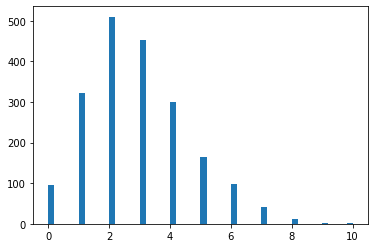

In [873]:
p = plt.hist(lens, bins=50)

In [6]:
def get_data(img_idx, return_img=False):
    img_name = imgs[img_idx]
    img_captions = [captions.iloc[img_idx * 5 + i]["caption_text"] for i in range(5)]
    img = Image.open(img_paths[img_idx]) if return_img else img_paths[img_idx]
    return img_name, img_captions, img

test = False
if test:
    img_idx = 666

    img_name, img_captions, img = get_data(img_idx, return_img=True)
    print(img_name)
    print(img_captions)
    img.show()

In [7]:
import clip
import torch
#print(clip.available_models())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_name = "ViT-B/16"
model, transform = clip.load(clip_name, jit=False, device=device)
load_path = None

In [8]:
from utils import get_image_features, get_text_features

test_sims = False
idx = 5002
personal_caption = ""


if test_sims:
    img_name, img_captions, img = get_data(idx)
    if len(personal_caption) > 0:
        img_captions.append(personal_caption)


    img_features = get_image_features([img], model, transform, device, 
                                      load_path, batch_size=16, save=False)
    caption_features = get_text_features(img_captions, model, device, 
                                         load_path, batch_size=16, save=False)

    sims = torch.cosine_similarity(img_features, caption_features)
    top_k = sims.topk(k=5)
    indices = top_k.indices
    vals = top_k.values

    Image.open(img).show()
    for idx, val in zip(indices, vals):
        print(val, img_captions[idx])

In [10]:
load_path = os.path.join(dataset, "feats")
os.makedirs(load_path, exist_ok=True)
bs = 128

img_features = get_image_features(img_paths, model, transform, device, 
                                  os.path.join(load_path, f"{clip_name}_img_feats.pt"), 
                                  batch_size=bs, save=True)
caption_features = get_text_features(captions["caption_text"], model, device, 
                                     os.path.join(load_path, f"{clip_name}_caption_feats.pt"), 
                                     batch_size=bs, save=False)

  0%|          | 0/1242 [00:00<?, ?it/s]

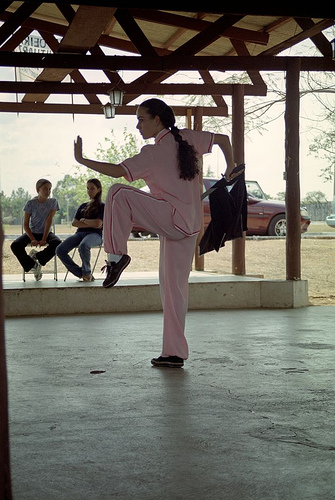

4970


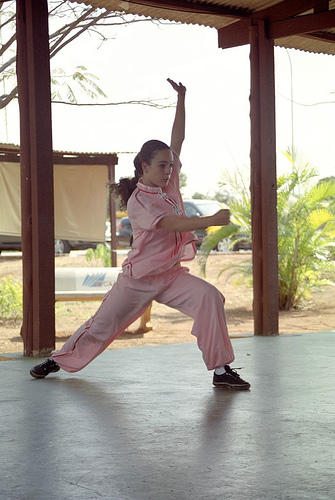

A young woman in a pink outfit practices martial arts on a covered patio . 

Real captions:
A woman dressed in a pink jumpsuit is performing a martial arts or dance move in an outdoor covered area .
A girl with a long braid and a pink outfit , poses in a martial arts position .
A girl in pink practices some sort of precision movement while two other girls watch .
A young female dancer , wearing a pink top and pants , with her hair pulled behind her in a long ponytail , executes a step with one raised leg bent at the knee , and both arms extended and bent at the wrist , while two young people sit on folding chairs and watch .
A woman dressed in pink is in a stance with one leg off the ground and one arm in the air .


In [41]:
# img2text
img_idx = 1005

sims = torch.cosine_similarity(img_features[img_idx].unsqueeze(0), caption_features)
Image.open(img_paths[img_idx]).show()
idx = sims.topk(k=1).indices[0].item()
print(idx)
get_data(idx // 5, return_img=True)[2].show()
print(captions["caption_text"].iloc[idx], "\n")
print("Real captions:")
for text in get_data(img_idx)[1]:
    print(text)

A man starts walking towards a bowling lane , appearing to be winding up for a bowl .
27414
Found:


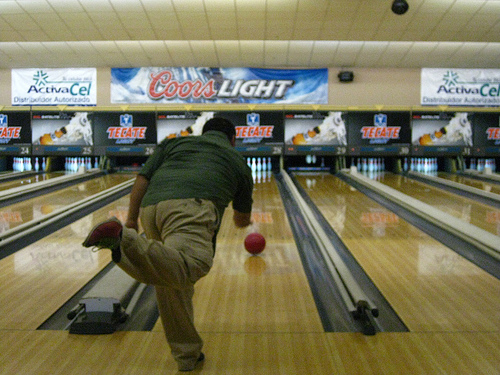

Ground truth: 


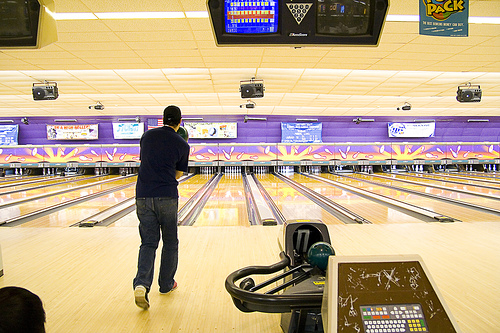

In [60]:
# text2img
text_idx = 5004

print(captions["caption_text"].iloc[text_idx])
sims = torch.cosine_similarity(caption_features[text_idx].unsqueeze(0), img_features)
idx = sims.topk(k=1).indices[0].item()
print(idx)
print("Found:")
Image.open(img_paths[idx]).show()
print("Ground truth: ")
Image.open(img_paths[text_idx // 5]).show()

In [312]:
from tqdm.auto import tqdm
from typing import List
import numpy as np

def calc_metrics(feats, caption_features):
    sims = torch.cosine_similarity(feats, caption_features)
    #pred_idcs: List[int] = sims.topk(k=10).indices.tolist()
    pred_idcs = sims.topk(k=10).indices
    return pred_idcs


def calc_img2text_retrieval(img_features, caption_features, cap_per_img=5):
    #calc_metrics = torch.jit.trace(calc_metrics, (img_features[0].unsqueeze(0), caption_features))
    r1 = torch.zeros(img_features.shape[0])
    r5 = torch.zeros(img_features.shape[0])
    r10 = torch.zeros(img_features.shape[0])
    for img_idx in torch.arange(img_features.shape[0], device=img_features.device):
        feats = img_features[img_idx].unsqueeze(0)
        #print(feats.device, caption_features.device, img_idx.device)
        pred_idcs = calc_metrics(feats, caption_features)
        ground_truth_idcs = torch.arange(cap_per_img, device=feats.device) + img_idx * cap_per_img
        r1_val = any([pred_idcs[i] in ground_truth_idcs for i in range(1)])
        r5_val = any([pred_idcs[i] in ground_truth_idcs for i in range(5)])
        r10_val = any([pred_idcs[i] in ground_truth_idcs for i in range(10)])
        r1[img_idx] = r1_val
        r5[img_idx] = r5_val
        r10[img_idx] = r10_val
    return r1, r5, r10


def calc_text2img_retrieval(caption_features, img_features, cap_per_img=5):
    r1 = torch.zeros(caption_features.shape[0])
    r5 = torch.zeros(caption_features.shape[0])
    r10 = torch.zeros(caption_features.shape[0])
    for cap_idx in torch.arange(caption_features.shape[0], device=caption_features.device):
        feats = caption_features[cap_idx].unsqueeze(0)
        #print(feats.device, caption_features.device, img_idx.device)
        pred_idcs = calc_metrics(feats, img_features)
        ground_truth_idx = cap_idx // cap_per_img
        r1_val = (pred_idcs[:1] == ground_truth_idx).max()
        r5_val = (pred_idcs[:5] == ground_truth_idx).max()
        r10_val = (pred_idcs[:10] == ground_truth_idx).max()
        r1[cap_idx] = r1_val
        r5[cap_idx] = r5_val
        r10[cap_idx] = r10_val
    return r1, r5, r10

In [299]:
query_feats = img_features[:].cuda()
target_feats = caption_features.cuda()

In [302]:
import time

now = time.time()
metrics = calc_img2text_retrieval(query_feats, target_feats)
print(time.time() - now)
for i in range(3):
    print(torch.mean(metrics[i]))

180.35698533058167
tensor(0.4409)
tensor(0.6825)
tensor(0.7711)


In [313]:
query_feats = caption_features[:].cuda()
target_feats = img_features.cuda()

now = time.time()
text2img_metrics = calc_text2img_retrieval(query_feats[:10000], target_feats)
print(time.time() - now)
for i in range(3):
    print(torch.mean(text2img_metrics[i]))

11.105646133422852
tensor(0.3195)
tensor(0.5563)
tensor(0.6488)


In [314]:
len(query_feats)

158915